In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

Le résulat de cette cellule est un dataframe avec la liste des tags par carton avec le nombre de tags dans chaque carton

Les cartons sont dans la cellule refListId_actual. Dans la colonne Q refList_actual on a le nombre de tags par carton

In [16]:
pathfile='data_anonymous'

# reflist: list of epc in each box
reflist=pd.DataFrame()
# 
files=os.listdir(pathfile) # retourne une liste des fichiers dans le répertoire pathfile
for file in files:
    #print(file)
    if file.startswith('reflist_'):
        temp=pd.read_csv(os.path.join(pathfile,file),sep=',').reset_index(drop=True)[['Epc']]
        temp['refListId']=file.split('.')[0]
        reflist = pd.concat([reflist, temp])
reflist=reflist.rename(columns={'refListId':'refListId_actual'})
reflist['refListId_actual']=reflist['refListId_actual'].apply(lambda x:int(x[8:]))
Q_refListId_actual=reflist.groupby('refListId_actual')['Epc'].nunique().rename('Q refListId_actual').reset_index(drop=False)
reflist=pd.merge(reflist,Q_refListId_actual,on='refListId_actual',how='left')
reflist.head(100)

,Epc,refListId_actual,Q refListId_actual
0,epc_90,0,16
1,epc_91,0,16
2,epc_92,0,16
3,epc_93,0,16
4,epc_94,0,16
...,...,...,...
95,epc_15,5,40
96,epc_16,5,40
97,epc_17,5,40
98,epc_18,5,40


Tags: logtime, epc, rssi, ant, loc

In [42]:
# pathfile=r'data_anonymous'
# 
# df : rfid readings
tags=pd.DataFrame()
# 
files=os.listdir(pathfile)
for file in files:
    #print(file)
    if file.startswith('ano_APTags'):
        temp=pd.read_csv(os.path.join(pathfile,file),sep=',')
        tags=pd.concat([tags,temp])
tags['LogTime']=pd.to_datetime (tags['LogTime'] ,format='%Y-%m-%d-%H:%M:%S') 
tags['TimeStamp']=tags['TimeStamp'].astype(float)
tags['Rssi']=tags['Rssi'].astype(float)
tags=tags.drop(['Reader','EmitPower','Frequency'],axis=1).reset_index(drop=True)
tags=tags[['LogTime', 'Epc', 'Rssi', 'Ant']]
# antennas 1 and 2 are facing the box when photocell in/out 
Ant_loc=pd.DataFrame({'Ant':[1,2,3,4],'loc':['in','in','out','out']})
tags=pd.merge(tags,Ant_loc,on=['Ant'])
tags=tags.sort_values('LogTime').reset_index(drop=True)
tags.head()

,LogTime,Epc,Rssi,Ant,loc
0,2019-11-07 15:32:10,epc_100,-69.0,3,out
1,2019-11-07 15:32:10,epc_97,-69.0,3,out
2,2019-11-07 15:32:10,epc_97,-65.0,3,out
3,2019-11-07 15:32:10,epc_99,-70.0,3,out
4,2019-11-07 15:32:10,epc_100,-66.0,3,out


Fenêtre de lecture

In [31]:
# timing: photocells a time window for each box: start/stop (ciuchStart, ciuchStop)
file='ano_supply-process.2019-11-07-CUT.csv'
timing=pd.read_csv(os.path.join(pathfile,file),sep=',')
timing['file']=file
timing['date']=pd.to_datetime(timing['date'],format='%d/%m/%Y %H:%M:%S,%f')
timing['Start']=pd.to_datetime(timing['ciuchStart'],format='%d/%m/%Y %H:%M:%S,%f')
timing['Stop']=pd.to_datetime(timing['ciuchStop'],format='%d/%m/%Y %H:%M:%S,%f')
timing['timestampStart']=timing['timestampStart'].astype(float)
timing['timestampStop']=timing['timestampStop'].astype(float)
timing=timing.sort_values('date')
timing.loc[:,'refListId']=timing.loc[:,'refListId'].apply(lambda x:int(x[8:]))
timing=timing[['refListId', 'Start', 'Stop']]
timing[:12]

,refListId,Start,Stop
0,0,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197
1,1,2019-11-07 18:54:02.637,2019-11-07 18:54:04.463
2,2,2019-11-07 18:54:13.587,2019-11-07 18:54:15.447
3,3,2019-11-07 18:54:17.942,2019-11-07 18:54:19.591
4,4,2019-11-07 18:54:23.683,2019-11-07 18:54:25.528
5,5,2019-11-07 18:54:29.422,2019-11-07 18:54:31.278
6,6,2019-11-07 18:54:34.953,2019-11-07 18:54:36.685
7,7,2019-11-07 18:54:40.829,2019-11-07 18:54:42.611
8,8,2019-11-07 18:54:46.383,2019-11-07 18:54:48.158
9,9,2019-11-07 18:54:52.122,2019-11-07 18:54:54.051


Fenêtre de décision: full window

In [34]:
# Start_up starts upstream Start, half way in between the previous stop and the actual start
timing[['Stop_last']]=timing[['Stop']].shift(1)
timing[['refListId_last']]=timing[['refListId']].shift(1)
timing['Startup']=timing['Start'] - (timing['Start'] - timing['Stop_last'])/2
# timing start: 10sec before timing
timing.loc[0,'refListId_last']=timing.loc[0,'refListId']
timing.loc[0,'Startup']=timing.loc[0,'Start']-datetime.timedelta(seconds=10)
timing.loc[0,'Stop_last']=timing.loc[0,'Startup']-datetime.timedelta(seconds=10)
timing['refListId_last']=timing['refListId_last'].astype(int)
# 
timing['Stopdown']= timing['Startup'].shift(-1)
timing.loc[len(timing)-1,'Stopdown']=timing.loc[len(timing)-1,'Stop']+datetime.timedelta(seconds=10)
timing=timing[['refListId', 'refListId_last','Startup', 'Start','Stop','Stopdown']]
timing.head(30)

,refListId,refListId_last,Startup,Start,Stop,Stopdown
0,0,0,2019-11-07 18:53:42.370000,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417000
1,1,0,2019-11-07 18:53:58.417000,2019-11-07 18:54:02.637,2019-11-07 18:54:04.463,2019-11-07 18:54:09.025000
2,2,1,2019-11-07 18:54:09.025000,2019-11-07 18:54:13.587,2019-11-07 18:54:15.447,2019-11-07 18:54:16.694500
3,3,2,2019-11-07 18:54:16.694500,2019-11-07 18:54:17.942,2019-11-07 18:54:19.591,2019-11-07 18:54:21.637000
4,4,3,2019-11-07 18:54:21.637000,2019-11-07 18:54:23.683,2019-11-07 18:54:25.528,2019-11-07 18:54:27.475000
5,5,4,2019-11-07 18:54:27.475000,2019-11-07 18:54:29.422,2019-11-07 18:54:31.278,2019-11-07 18:54:33.115500
6,6,5,2019-11-07 18:54:33.115500,2019-11-07 18:54:34.953,2019-11-07 18:54:36.685,2019-11-07 18:54:38.757000
7,7,6,2019-11-07 18:54:38.757000,2019-11-07 18:54:40.829,2019-11-07 18:54:42.611,2019-11-07 18:54:44.497000
8,8,7,2019-11-07 18:54:44.497000,2019-11-07 18:54:46.383,2019-11-07 18:54:48.158,2019-11-07 18:54:50.140000
9,9,8,2019-11-07 18:54:50.140000,2019-11-07 18:54:52.122,2019-11-07 18:54:54.051,2019-11-07 18:54:55.894500


In [35]:
# box 0 always starts
timing[timing['refListId']==0].head()

,refListId,refListId_last,Startup,Start,Stop,Stopdown
0,0,0,2019-11-07 18:53:42.370000,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417000
10,0,9,2019-11-07 18:54:55.894500,2019-11-07 18:54:57.738,2019-11-07 18:54:59.584,2019-11-07 18:55:01.765000
20,0,9,2019-11-07 18:55:53.460500,2019-11-07 18:55:55.497,2019-11-07 18:55:57.377,2019-11-07 18:55:59.567500
30,0,9,2019-11-07 18:56:51.317000,2019-11-07 18:56:53.344,2019-11-07 18:56:55.215,2019-11-07 18:56:57.241500
40,0,9,2019-11-07 18:58:02.390500,2019-11-07 18:58:04.351,2019-11-07 18:58:06.212,2019-11-07 18:58:11.428000


In [36]:
# t0_run = a new run starts when box 0 shows up
t0_run=timing[timing['refListId']==0] [['Startup']]
t0_run=t0_run.rename(columns={'Startup':'t0_run'})
t0_run=t0_run.groupby('t0_run').size().cumsum().rename('run').reset_index(drop=False)
t0_run=t0_run.sort_values('t0_run')
# 
# each row in timing is merged with a last row in t0_run where t0_run (ciuchstart) <= timing (ciuchstart)
timing=pd.merge_asof(timing,t0_run,left_on='Startup',right_on='t0_run', direction='backward')
timing=timing.sort_values('Stop')
timing=timing[['run', 'refListId', 'refListId_last', 'Startup','Start','Stop','Stopdown','t0_run']]
timing.head()

,run,refListId,refListId_last,Startup,Start,Stop,Stopdown,t0_run
0,1,0,0,2019-11-07 18:53:42.370000,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417000,2019-11-07 18:53:42.370
1,1,1,0,2019-11-07 18:53:58.417000,2019-11-07 18:54:02.637,2019-11-07 18:54:04.463,2019-11-07 18:54:09.025000,2019-11-07 18:53:42.370
2,1,2,1,2019-11-07 18:54:09.025000,2019-11-07 18:54:13.587,2019-11-07 18:54:15.447,2019-11-07 18:54:16.694500,2019-11-07 18:53:42.370
3,1,3,2,2019-11-07 18:54:16.694500,2019-11-07 18:54:17.942,2019-11-07 18:54:19.591,2019-11-07 18:54:21.637000,2019-11-07 18:53:42.370
4,1,4,3,2019-11-07 18:54:21.637000,2019-11-07 18:54:23.683,2019-11-07 18:54:25.528,2019-11-07 18:54:27.475000,2019-11-07 18:53:42.370


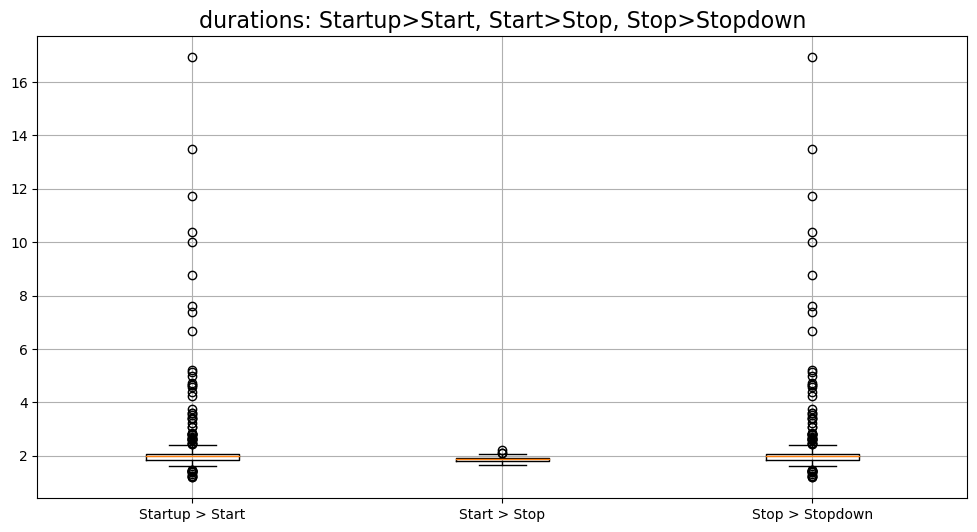

In [38]:
plt.figure(figsize=(12,6))
up=(timing['Start']-timing['Startup']).apply(lambda x:x.total_seconds())
mid=(timing['Stop']-timing['Start']).apply(lambda x:x.total_seconds())
down=(timing['Stopdown']-timing['Stop']).apply(lambda x:x.total_seconds())
plt.boxplot([up,mid,down],labels=['Startup > Start','Start > Stop','Stop > Stopdown'])
plt.grid()
plt.title('durations: Startup>Start, Start>Stop, Stop>Stopdown',size=16)
plt.show()

In [41]:
#  full window (Startup > Stopdown) is sliced in smaller slices
# Startup > Start: 11 slices named up_0, up_1, ..., up_10
# Start > Stop: 11 slices named mid_0, mid_1, ... mid_10
# Stop > Stopdown: 11 slices names down_0, down_1, ... down_10
slices=pd.DataFrame()
for i, row in timing.iterrows(): 
    ciuchStartup=row['Startup']
    ciuchStart=row['Start']
    ciuchStop=row['Stop']
    ciuchStopdown=row['Stopdown']
    steps=4
#     
    up=pd.DataFrame(index=pd.date_range(start=ciuchStartup, end=ciuchStart,periods=steps)).reset_index(drop=False).rename(columns={'index':'slice'})
    up.index=['up_'+str(x) for x in range(steps)]
    slices= pd.concat([slices, up])    
  
    mid=pd.DataFrame(index=pd.date_range(start=ciuchStart, end=ciuchStop,periods=steps)).reset_index(drop=False).rename(columns={'index':'slice'})
    mid.index=['mid_'+str(x) for x in range(steps)]
    slices= pd.concat([slices, mid])
#     
    down=pd.DataFrame(index=pd.date_range(start=ciuchStop, end=ciuchStopdown,periods=steps)).reset_index(drop=False).rename(columns={'index':'slice'})
    down.index=['down_'+str(x) for x in range(steps)]
    slices= pd.concat([slices, down])

slices=slices.reset_index(drop=False).rename(columns={'index':'slice_id'})
# 
timing_slices=pd.merge_asof(slices,timing,left_on='slice',right_on='Startup',direction='backward')
timing_slices=timing_slices[['run', 'refListId', 'refListId_last','slice_id','slice',  \
                             'Startup', 'Start', 'Stop', 'Stopdown','t0_run']]
timing_slices.head()

,run,refListId,refListId_last,slice_id,slice,Startup,Start,Stop,Stopdown,t0_run
0,1,0,0,up_0,2019-11-07 18:53:42.370000000,2019-11-07 18:53:42.370,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,2019-11-07 18:53:42.370
1,1,0,0,up_1,2019-11-07 18:53:45.703333333,2019-11-07 18:53:42.370,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,2019-11-07 18:53:42.370
2,1,0,0,up_2,2019-11-07 18:53:49.036666666,2019-11-07 18:53:42.370,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,2019-11-07 18:53:42.370
3,1,0,0,up_3,2019-11-07 18:53:52.370000000,2019-11-07 18:53:42.370,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,2019-11-07 18:53:42.370
4,1,0,0,mid_0,2019-11-07 18:53:52.370000000,2019-11-07 18:53:42.370,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,2019-11-07 18:53:42.370


Fusion des dataframes tags et timing_slices: df_timing_slices

In [46]:
# merge between tags and timing
# merge_asof needs sorted df > df_ref
df = tags
df=df[(tags['LogTime']>=timing['Startup'].min()) & (df['LogTime']<=timing['Stopdown'].max())]
df=df.sort_values('LogTime')
# 
# each row in df_ref is merged with the last row in timing where timing (ciuchstart_up) < df_ref (logtime)
# 
# df_timing=pd.merge_asof(df_ref,timing,left_on=['LogTime'],right_on=['ciuchStartup'],direction='backward')
# df_timing=df_timing.dropna()
# df_timing=df_timing.sort_values('LogTime').reset_index(drop=True)
# df_timing=df_timing[['run', 'Epc','refListId', 'refListId_last', 'ciuchStartup',\
#                      'LogTime', 'ciuchStop', 'ciuchStopdown','Rssi', 'loc', 'refListId_actual']]
# 
# each row in df_ref is merged with the last row in timing_slices where timing (slice) < df_ref (logtime)
# 
df_timing_slices=pd.merge_asof(df,timing_slices,left_on=['LogTime'],right_on=['slice'],direction='backward')
df_timing_slices=df_timing_slices.dropna()
df_timing_slices=df_timing_slices.sort_values('slice').reset_index(drop=True)
df_timing_slices=df_timing_slices[['run', 'Epc','refListId', 'refListId_last', 'Startup','slice_id','slice','LogTime','Start','Stop', 'Stopdown', 'Rssi', 'loc','t0_run']]
df_timing_slices


C:\Users\jarfi\AppData\Local\Temp\ipykernel_48492\4033682936.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df[(tags['LogTime']>=timing['Startup'].min()) & (tags['LogTime']<=timing['Stopdown'].max())]


,run,Epc,refListId,refListId_last,Startup,slice_id,slice,LogTime,Start,Stop,Stopdown,Rssi,loc,t0_run
0,1,epc_131,0,0,2019-11-07 18:53:42.370,up_0,2019-11-07 18:53:42.370000000,2019-11-07 18:53:43,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,-62.0,out,2019-11-07 18:53:42.370
1,1,epc_133,0,0,2019-11-07 18:53:42.370,up_0,2019-11-07 18:53:42.370000000,2019-11-07 18:53:45,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,-59.0,in,2019-11-07 18:53:42.370
2,1,epc_133,0,0,2019-11-07 18:53:42.370,up_0,2019-11-07 18:53:42.370000000,2019-11-07 18:53:45,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,-64.0,in,2019-11-07 18:53:42.370
3,1,epc_134,0,0,2019-11-07 18:53:42.370,up_0,2019-11-07 18:53:42.370000000,2019-11-07 18:53:45,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,-71.0,in,2019-11-07 18:53:42.370
4,1,epc_137,0,0,2019-11-07 18:53:42.370,up_0,2019-11-07 18:53:42.370000000,2019-11-07 18:53:45,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,-65.0,in,2019-11-07 18:53:42.370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356063,40,epc_167,1,0,2019-11-07 19:34:44.230,down_2,2019-11-07 19:34:55.305666666,2019-11-07 19:34:57,2019-11-07 19:34:46.836,2019-11-07 19:34:48.639,2019-11-07 19:34:58.639,-72.0,out,2019-11-07 19:34:37.679
356064,40,epc_188,1,0,2019-11-07 19:34:44.230,down_2,2019-11-07 19:34:55.305666666,2019-11-07 19:34:57,2019-11-07 19:34:46.836,2019-11-07 19:34:48.639,2019-11-07 19:34:58.639,-65.0,out,2019-11-07 19:34:37.679
356065,40,epc_87,1,0,2019-11-07 19:34:44.230,down_2,2019-11-07 19:34:55.305666666,2019-11-07 19:34:57,2019-11-07 19:34:46.836,2019-11-07 19:34:48.639,2019-11-07 19:34:58.639,-70.0,out,2019-11-07 19:34:37.679
356066,40,epc_188,1,0,2019-11-07 19:34:44.230,down_2,2019-11-07 19:34:55.305666666,2019-11-07 19:34:57,2019-11-07 19:34:46.836,2019-11-07 19:34:48.639,2019-11-07 19:34:58.639,-59.0,out,2019-11-07 19:34:37.679
